<div style="padding:18px;background-color:#03045e;border-radius:12px;text-align:center;color:white;font-family:'Rajdhani',-apple-system,BlinkMacSystemFont,'Segoe UI','Roboto','Helvetica Neue',Arial,sans-serif;">
<div style="font-size:36px;font-weight:700;">INTEGRITY AUDIT</div>
<div style="font-size:16px;font-weight:500;opacity:0.75;">Adversarial Stress Analysis | Part : 1</div>
</div>

# <div style="padding:18px;background-color:#03045e;border-radius:12px;text-align:center;color:white;font-family:'Rajdhani',-apple-system,BlinkMacSystemFont,'Segoe UI','Roboto','Helvetica Neue',Arial,sans-serif;font-size:36px;font-weight:700;">Setup and Initialization</div>

<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

## **Loading Baseline Models and Data**
Similar to the foundation notebook, this integrity audit notebook requires loading all necessary components from the baseline notebook outputs or input dataset. The setup process includes:

* **Loading raw data:** Training and test images (`X_train`, `X_test`), labels (`y_train`, `y_test`), and tabular features from previous experiments
* **Loading trained models:** Pre-trained `dual_image_client`, `dual_tabular_client`, and `transformer_server` models
* **Loading or computing embeddings:** Feature embeddings (`test_spec_img`, `test_inv_img`, `test_spec_tab`, `test_inv_tab` and corresponding training set variables) for both training and test sets (cached when available)
* **Computing baseline metrics:** Establishing baseline performance metrics (`vfl4_test_acc`, `vfl4_balanced_acc`, `per_class_acc`) for comparison with attack results

This setup ensures that all integrity attacks can be evaluated against a consistent baseline model and data configuration.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, clone_model
from tensorflow.keras.layers import (Input, Concatenate, Dense, Dropout, 
                                     LayerNormalization, MultiHeadAttention, 
                                     Reshape, Flatten)
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score
import seaborn as sns
import pickle
import warnings
import os
from IPython.display import HTML, display

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
warnings.filterwarnings('ignore')

ENABLE_CACHING = True
INPUT_DATASET_DIR = '/kaggle/input/hybridvfl-exp-4/'
WORKING_DIR = '/kaggle/working/'
CACHE_DIR = '/kaggle/working/cache/'
BASE_PATH_EXP1 = '/kaggle/input/hybridvfl-exp-1/'
BASE_PATH_EXP2 = '/kaggle/input/hybridvfl-exp-2/'

ASSET_NAMES = {
    'dual_image_client': 'exp4_dual_image_client.keras',
    'dual_tabular_client': 'exp4_dual_tabular_client.keras',
    'transformer_server': 'exp4_transformer_server.keras',
    'train_embeddings': 'cache/train_embeddings.npz',
    'test_embeddings': 'cache/test_embeddings.npz',
}

os.makedirs(CACHE_DIR, exist_ok=True)

def find_asset(asset_name):
    input_path = INPUT_DATASET_DIR + ASSET_NAMES[asset_name]
    if os.path.isfile(input_path):
        return input_path
    if asset_name in ['train_embeddings', 'test_embeddings']:
        working_path = CACHE_DIR + ASSET_NAMES[asset_name].replace('cache/', '')
    else:
        working_path = WORKING_DIR + ASSET_NAMES[asset_name]
    if os.path.isfile(working_path):
        return working_path
    return None

def embeddings_cached():
    return (find_asset('test_embeddings') is not None and
            find_asset('train_embeddings') is not None)

X_train = np.load(BASE_PATH_EXP1 + 'X_train.npy')
X_test = np.load(BASE_PATH_EXP1 + 'X_test.npy')
y_train = np.load(BASE_PATH_EXP1 + 'y_train.npy')
y_test = np.load(BASE_PATH_EXP1 + 'y_test.npy')
train_tabular_features = np.load(BASE_PATH_EXP2 + 'train_tabular_features.npy')
test_tabular_features = np.load(BASE_PATH_EXP2 + 'test_tabular_features.npy')

with open(BASE_PATH_EXP1 + 'class_weight_dict.pkl', 'rb') as f:
    class_weight_dict = pickle.load(f)

img_path = find_asset('dual_image_client')
tab_path = find_asset('dual_tabular_client')
server_path = find_asset('transformer_server')

if not (img_path and tab_path and server_path):
    raise FileNotFoundError("Required models not found. Please ensure baseline notebook has been run and models are saved.")

dual_image_client = load_model(img_path)
dual_tabular_client = load_model(tab_path)
transformer_server = load_model(server_path)

if ENABLE_CACHING and embeddings_cached():
    test_emb_path = find_asset('test_embeddings')
    train_emb_path = find_asset('train_embeddings')
    test_embeddings = np.load(test_emb_path)
    test_spec_img = test_embeddings['spec_img']
    test_inv_img = test_embeddings['inv_img']
    test_spec_tab = test_embeddings['spec_tab']
    test_inv_tab = test_embeddings['inv_tab']
    train_embeddings = np.load(train_emb_path)
    train_spec_img = train_embeddings['spec_img']
    train_inv_img = train_embeddings['inv_img']
    train_spec_tab = train_embeddings['spec_tab']
    train_inv_tab = train_embeddings['inv_tab']
else:
    test_spec_img, test_inv_img = dual_image_client.predict(X_test, verbose=0)
    test_spec_tab, test_inv_tab = dual_tabular_client.predict(test_tabular_features, verbose=0)
    train_spec_img, train_inv_img = dual_image_client.predict(X_train, verbose=0)
    train_spec_tab, train_inv_tab = dual_tabular_client.predict(train_tabular_features, verbose=0)

test_predictions = transformer_server.predict([test_spec_img, test_inv_img, test_spec_tab, test_inv_tab], verbose=0)
y_pred = np.argmax(test_predictions, axis=1)
y_true = np.argmax(y_test, axis=1)
vfl4_test_acc = accuracy_score(y_true, y_pred)
vfl4_balanced_acc = balanced_accuracy_score(y_true, y_pred)
lesion_types = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print(f"Setup complete: Baseline accuracy = {vfl4_test_acc:.4f}, Balanced accuracy = {vfl4_balanced_acc:.4f}")

2025-12-24 17:42:35.067390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766598155.266095      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766598155.319957      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766598155.793992      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766598155.794026      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766598155.794029      24 computation_placer.cc:177] computation placer alr

Setup complete: Baseline accuracy = 0.8925, Balanced accuracy = 0.9285


# <div style="padding:18px;background-color:#03045e;border-radius:12px;text-align:center;color:white;font-family:'Rajdhani',-apple-system,BlinkMacSystemFont,'Segoe UI','Roboto','Helvetica Neue',Arial,sans-serif;font-size:36px;font-weight:700;">Integrity Attacks</div>

<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

## **Untargeted Noise Attack**
This attack simulates a compromised or malfunctioning image client that sends random noise instead of valid image data. In real-world scenarios, this could occur due to sensor malfunctions, environmental interference, or hardware degradation in edge devices like digital dermatoscopes.

We evaluate two noise intensities:

* **Mild noise** (`NOISE_SCALE_MILD = 0.2`): Represents realistic failure modes such as sensor noise, ISO grain, or slight blur
* **Severe noise** (`NOISE_SCALE_SEVERE = 1.0`): Represents severe corruption scenarios such as out-of-focus images, hardware malfunction, or obstructed lens

The attack injects Gaussian noise directly into the image embeddings (`test_spec_img` and `test_inv_img`) while keeping tabular embeddings clean, simulating a scenario where only the image client is compromised. The goal is to measure how noise magnitude affects model robustness and performance degradation across different lesion types.

In [2]:
NOISE_SCALE_MILD = 0.2
NOISE_SCALE_SEVERE = 1.0

original_test_spec_img = test_spec_img.copy()
original_test_inv_img = test_inv_img.copy()
clean_test_spec_tab = test_spec_tab
clean_test_inv_tab = test_inv_tab

noise_attack_results = {}

for noise_scale, noise_type in [(NOISE_SCALE_MILD, 'mild'), (NOISE_SCALE_SEVERE, 'severe')]:
    noise_spec_img = np.random.normal(0, noise_scale, original_test_spec_img.shape)
    noise_inv_img = np.random.normal(0, noise_scale, original_test_inv_img.shape)
    
    noisy_test_spec_img = original_test_spec_img + noise_spec_img
    noisy_test_inv_img = original_test_inv_img + noise_inv_img
    
    noise_predictions = transformer_server.predict(
        [noisy_test_spec_img, noisy_test_inv_img, clean_test_spec_tab, clean_test_inv_tab], 
        verbose=0
    )
    
    y_pred_noise = np.argmax(noise_predictions, axis=1)
    noise_test_acc = accuracy_score(y_true, y_pred_noise)
    noise_balanced_acc = balanced_accuracy_score(y_true, y_pred_noise)
    
    cm_noise = confusion_matrix(y_true, y_pred_noise)
    per_class_acc_noise = cm_noise.diagonal() / cm_noise.sum(axis=1)
    
    noise_attack_results[noise_type] = {
        'noise_scale': noise_scale,
        'accuracy': noise_test_acc,
        'balanced_acc': noise_balanced_acc,
        'accuracy_drop': vfl4_test_acc - noise_test_acc,
        'balanced_acc_drop': vfl4_balanced_acc - noise_balanced_acc,
        'per_class_acc': per_class_acc_noise
    }

noise_results_data = []
for noise_type in ['mild', 'severe']:
    results = noise_attack_results[noise_type]
    noise_results_data.append({
        "Noise Level": noise_type.capitalize(),
        "Noise Scale": f"{results['noise_scale']:.2f}",
        "Original Accuracy": f"{vfl4_test_acc:.4f}",
        "Attacked Accuracy": f"{results['accuracy']:.4f}",
        "Accuracy Drop": f"{results['accuracy_drop']:.4f}",
        "Original Balanced Acc": f"{vfl4_balanced_acc:.4f}",
        "Attacked Balanced Acc": f"{results['balanced_acc']:.4f}",
        "Balanced Acc Drop": f"{results['balanced_acc_drop']:.4f}"
    })

df_noise_results = pd.DataFrame(noise_results_data)
html_noise_results = df_noise_results.to_html(index=False, classes='table table-striped table-bordered', table_id='noise_attack_results')
display(HTML("<h4>Untargeted Noise Attack Results</h4>" + html_noise_results))

Noise Level,Noise Scale,Original Accuracy,Attacked Accuracy,Accuracy Drop,Original Balanced Acc,Attacked Balanced Acc,Balanced Acc Drop
Mild,0.20,0.8925,0.8846,0.0079,0.9285,0.9198,0.0087
Severe,1.00,0.8925,0.7182,0.1743,0.9285,0.7082,0.2203


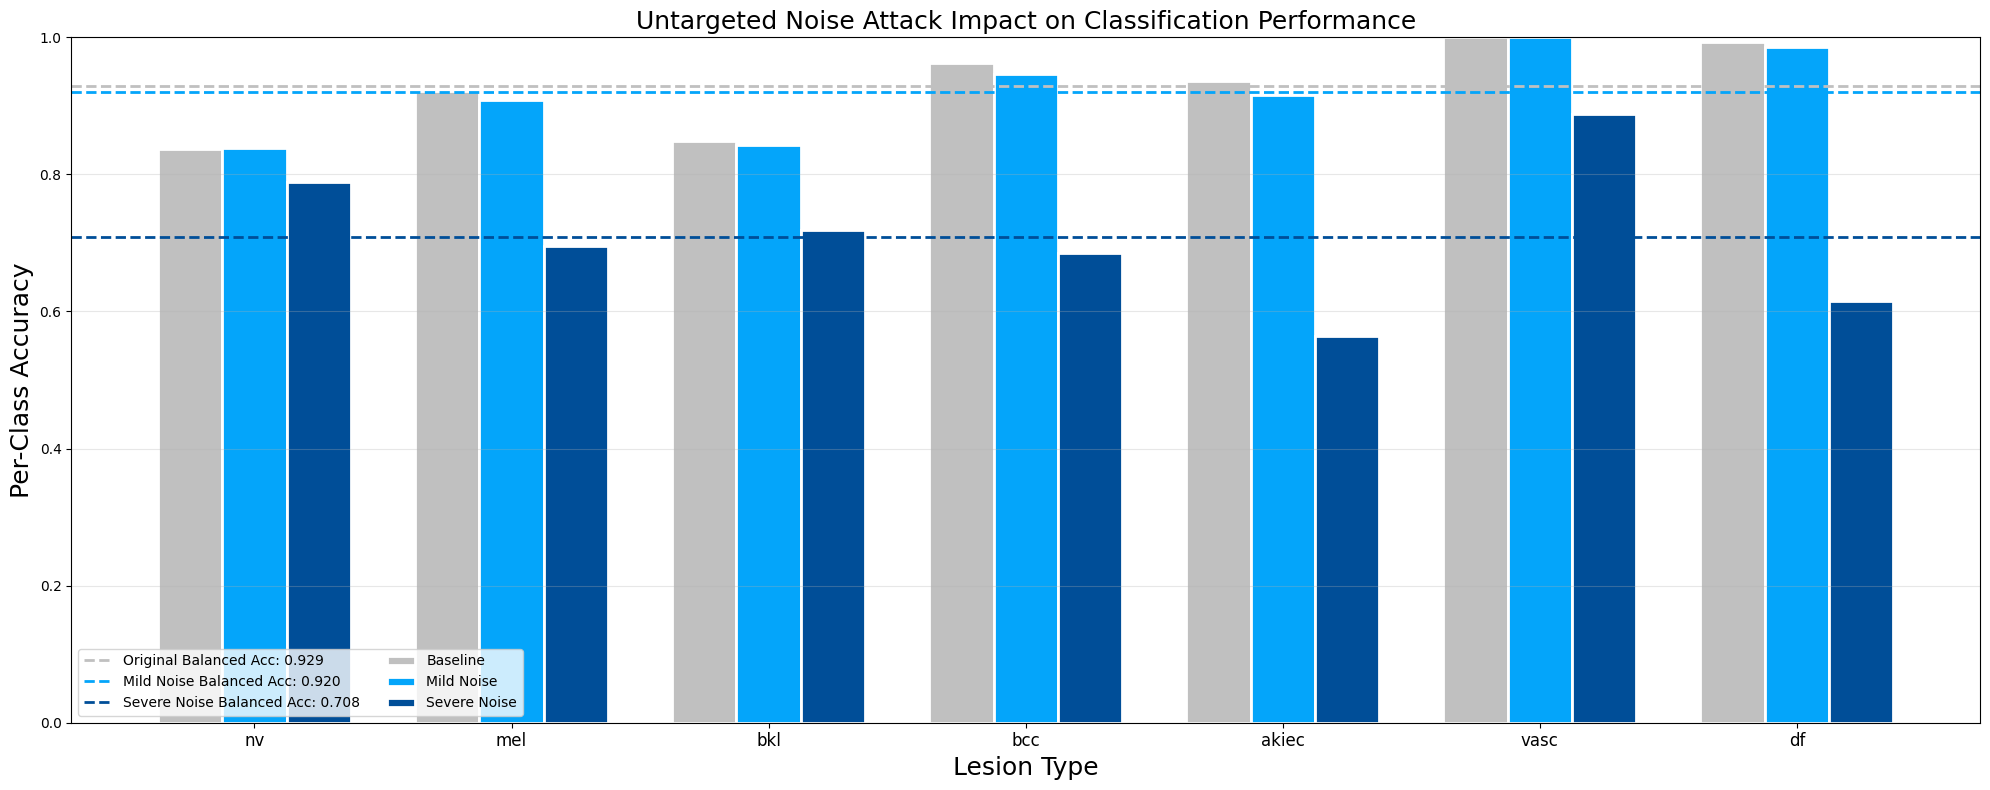

Metric,Original,Mild (0.2),Severe (1.0),Drop (Severe)
Standard Accuracy,0.8925,0.8846,0.7182,0.1743
Balanced Accuracy,0.9285,0.9198,0.7082,0.2203


Class,Original,Mild (0.2),Severe (1.0),Drop (Severe)
nv,0.8367,0.8389,0.7882,0.0485
mel,0.9222,0.9087,0.6961,0.2260
bkl,0.8491,0.8431,0.7195,0.1296
bcc,0.9627,0.9465,0.6856,0.2771
akiec,0.9362,0.9158,0.5638,0.3724
vasc,1.0000,1.0000,0.8882,0.1118
df,0.9928,0.9855,0.6159,0.3768


In [3]:
fig, ax = plt.subplots(figsize=(20, 8))

x_pos = np.arange(len(lesion_types))
width = 0.25

per_class_mild = noise_attack_results['mild']['per_class_acc']
per_class_severe = noise_attack_results['severe']['per_class_acc']
balanced_mild = noise_attack_results['mild']['balanced_acc']
balanced_severe = noise_attack_results['severe']['balanced_acc']

bars_original = ax.bar(x_pos - width, per_class_acc, width, 
                       label='Baseline', color='#C0C0C0', edgecolor='white', linewidth=2)
bars_mild = ax.bar(x_pos, per_class_mild, width,
                   label='Mild Noise', color='#04A5FA', edgecolor='white', linewidth=2)
bars_severe = ax.bar(x_pos + width, per_class_severe, width,
                     label='Severe Noise', color='#004E98', edgecolor='white', linewidth=2)

ax.axhline(y=vfl4_balanced_acc, color='#C0C0C0', linestyle='--', linewidth=2, 
           label=f'Original Balanced Acc: {vfl4_balanced_acc:.3f}')
ax.axhline(y=balanced_mild, color='#04A5FA', linestyle='--', linewidth=2,
           label=f'Mild Noise Balanced Acc: {balanced_mild:.3f}')
ax.axhline(y=balanced_severe, color='#004E98', linestyle='--', linewidth=2,
           label=f'Severe Noise Balanced Acc: {balanced_severe:.3f}')

ax.set_xlabel('Lesion Type', fontsize=18, fontweight='normal')
ax.set_ylabel('Per-Class Accuracy', fontsize=18, fontweight='normal')
ax.set_title('Untargeted Noise Attack Impact on Classification Performance', 
             fontsize=18, fontweight='normal')
ax.set_xticks(x_pos)
ax.set_xticklabels(lesion_types, fontsize=12)
ax.set_ylim([0, 1])
ax.legend(loc='lower left', fontsize=10, ncol=2)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

overall_perf_data = [
    {
        "Metric": "Standard Accuracy",
        "Original": f"{vfl4_test_acc:.4f}",
        "Mild (0.2)": f"{noise_attack_results['mild']['accuracy']:.4f}",
        "Severe (1.0)": f"{noise_attack_results['severe']['accuracy']:.4f}",
        "Drop (Severe)": f"{noise_attack_results['severe']['accuracy_drop']:.4f}"
    },
    {
        "Metric": "Balanced Accuracy",
        "Original": f"{vfl4_balanced_acc:.4f}",
        "Mild (0.2)": f"{balanced_mild:.4f}",
        "Severe (1.0)": f"{balanced_severe:.4f}",
        "Drop (Severe)": f"{noise_attack_results['severe']['balanced_acc_drop']:.4f}"
    }
]
df_overall = pd.DataFrame(overall_perf_data)
html_overall = df_overall.to_html(index=False, classes='table table-striped table-bordered', table_id='overall_performance')
display(HTML("<h4>Overall Performance Comparison</h4>" + html_overall))

per_class_data = []
for i, lesion in enumerate(lesion_types):
    drop_severe = per_class_acc[i] - per_class_severe[i]
    per_class_data.append({
        "Class": lesion,
        "Original": f"{per_class_acc[i]:.4f}",
        "Mild (0.2)": f"{per_class_mild[i]:.4f}",
        "Severe (1.0)": f"{per_class_severe[i]:.4f}",
        "Drop (Severe)": f"{drop_severe:.4f}"
    })
df_per_class = pd.DataFrame(per_class_data)
html_per_class = df_per_class.to_html(index=False, classes='table table-striped table-bordered', table_id='per_class_accuracy')
display(HTML("<h4>Per-Class Accuracy Comparison</h4>" + html_per_class))

<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

## **Targeted Label-Flipping Attack**
This attack simulates a malicious insider who selectively flips labels during training to induce dangerous misclassifications while preserving overall accuracy. In real-world scenarios, this could occur if a compromised data annotator or a malicious participant in federated learning intentionally mislabels critical cases.

The attack targets a specific class pair:
* **Source class** (`SOURCE_CLASS = 'mel'`): Melanoma, a deadly skin cancer
* **Target class** (`TARGET_CLASS = 'nv'`): Nevus, a benign lesion

Attack parameters:
* **Poison rate** (`POISON_RATE = 0.5`): Percentage of source class samples to flip
* **Retraining epochs** (`RETRAIN_EPOCHS = 10`): Number of epochs for fine-tuning

Only the classification head is retrained while keeping the backbone frozen, simulating a scenario where an attacker has limited access to modify only the final layers of the model. This approach tests whether the attack can successfully increase melanoma-to-nevus misclassification while maintaining stealth by preserving overall model performance.

In [4]:
SOURCE_CLASS = 'mel'
TARGET_CLASS = 'nv'
POISON_RATE = 0.5
RETRAIN_EPOCHS = 10

source_idx = lesion_types.index(SOURCE_CLASS)
target_idx = lesion_types.index(TARGET_CLASS)

train_spec_img_full = train_spec_img.copy()
train_inv_img_full = train_inv_img.copy()
train_spec_tab_full = train_spec_tab.copy()
train_inv_tab_full = train_inv_tab.copy()
y_train_clean = y_train.copy()

y_train_poisoned = y_train_clean.copy()
source_indices = np.where(np.argmax(y_train_clean, axis=1) == source_idx)[0]
num_to_flip = int(len(source_indices) * POISON_RATE)

np.random.seed(RANDOM_STATE)
flip_indices = np.random.choice(source_indices, size=num_to_flip, replace=False)

for idx in flip_indices:
    y_train_poisoned[idx] = np.zeros(7)
    y_train_poisoned[idx, target_idx] = 1

poisoned_server = clone_model(transformer_server)
poisoned_server.set_weights(transformer_server.get_weights())

for layer in poisoned_server.layers:
    if layer.name in ['server_fc1', 'server_fc2', 'server_output']:
        layer.trainable = True
    else:
        layer.trainable = False

poisoned_server.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_poisoned = poisoned_server.fit(
    [train_spec_img_full, train_inv_img_full, train_spec_tab_full, train_inv_tab_full],
    y_train_poisoned,
    epochs=RETRAIN_EPOCHS,
    batch_size=64,
    validation_split=0.1,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8419 - loss: 0.2049 - val_accuracy: 0.8537 - val_loss: 0.2620
Epoch 2/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8591 - loss: 0.1611 - val_accuracy: 0.8523 - val_loss: 0.2534
Epoch 3/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8626 - loss: 0.1517 - val_accuracy: 0.8631 - val_loss: 0.2443
Epoch 4/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8716 - loss: 0.1453 - val_accuracy: 0.8612 - val_loss: 0.2450
Epoch 5/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8803 - loss: 0.1363 - val_accuracy: 0.8556 - val_loss: 0.2510
Epoch 6/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8830 - loss: 0.1350 - val_accuracy: 0.8561 - val_loss: 0.2472
Epoch 7/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8882 - loss: 0.1290 - val_accuracy: 0.8556 - val_loss: 0.2538
Epoch 8/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8937 - loss: 0.1257 - val_accuracy: 0

In [5]:
baseline_predictions = transformer_server.predict(
    [test_spec_img, test_inv_img, test_spec_tab, test_inv_tab], 
    verbose=0
)
y_pred_baseline = np.argmax(baseline_predictions, axis=1)

poisoned_predictions = poisoned_server.predict(
    [test_spec_img, test_inv_img, test_spec_tab, test_inv_tab],
    verbose=0
)
y_pred_poisoned = np.argmax(poisoned_predictions, axis=1)

mel_test_indices = np.where(y_true == source_idx)[0]
mel_test_count = len(mel_test_indices)

baseline_mel_correct = np.sum(y_pred_baseline[mel_test_indices] == source_idx)
baseline_mel_recall = baseline_mel_correct / mel_test_count
baseline_mel_to_nv = np.sum(y_pred_baseline[mel_test_indices] == target_idx)
baseline_mel_to_nv_rate = baseline_mel_to_nv / mel_test_count
baseline_balanced_acc = balanced_accuracy_score(y_true, y_pred_baseline)

poisoned_mel_correct = np.sum(y_pred_poisoned[mel_test_indices] == source_idx)
poisoned_mel_recall = poisoned_mel_correct / mel_test_count
poisoned_mel_to_nv = np.sum(y_pred_poisoned[mel_test_indices] == target_idx)
poisoned_mel_to_nv_rate = poisoned_mel_to_nv / mel_test_count
poisoned_balanced_acc = balanced_accuracy_score(y_true, y_pred_poisoned)

label_flip_results = {
    'source_class': SOURCE_CLASS,
    'target_class': TARGET_CLASS,
    'poison_rate': POISON_RATE,
    'baseline': {
        'mel_recall': baseline_mel_recall,
        'mel_to_nv_rate': baseline_mel_to_nv_rate,
        'balanced_acc': baseline_balanced_acc
    },
    'poisoned': {
        'mel_recall': poisoned_mel_recall,
        'mel_to_nv_rate': poisoned_mel_to_nv_rate,
        'balanced_acc': poisoned_balanced_acc
    },
    'changes': {
        'mel_recall_change': poisoned_mel_recall - baseline_mel_recall,
        'mel_to_nv_rate_change': poisoned_mel_to_nv_rate - baseline_mel_to_nv_rate,
        'balanced_acc_change': poisoned_balanced_acc - baseline_balanced_acc
    }
}

label_flip_data = [
    {
        "Metric": "Melanoma Samples in Test Set",
        "Value": f"{mel_test_count}"
    },
    {
        "Metric": "Baseline Melanoma Recall",
        "Value": f"{baseline_mel_recall:.4f}"
    },
    {
        "Metric": "Poisoned Melanoma Recall",
        "Value": f"{poisoned_mel_recall:.4f}"
    },
    {
        "Metric": "Melanoma Recall Change",
        "Value": f"{label_flip_results['changes']['mel_recall_change']:.4f}"
    },
    {
        "Metric": "Baseline Mel→Nv Rate",
        "Value": f"{baseline_mel_to_nv_rate:.4f}"
    },
    {
        "Metric": "Poisoned Mel→Nv Rate",
        "Value": f"{poisoned_mel_to_nv_rate:.4f}"
    },
    {
        "Metric": "Mel→Nv Rate Change",
        "Value": f"{label_flip_results['changes']['mel_to_nv_rate_change']:.4f}"
    }
]
df_label_flip = pd.DataFrame(label_flip_data)
html_label_flip = df_label_flip.to_html(index=False, classes='table table-striped table-bordered', table_id='label_flip_results')
display(HTML("<h4>Targeted Label-Flipping Attack Results</h4>" + html_label_flip))

Metric,Value
Melanoma Samples in Test Set,1336
Baseline Melanoma Recall,0.9222
Poisoned Melanoma Recall,0.3802
Melanoma Recall Change,-0.5419
Baseline Mel→Nv Rate,0.0337
Poisoned Mel→Nv Rate,0.5599
Mel→Nv Rate Change,0.5262


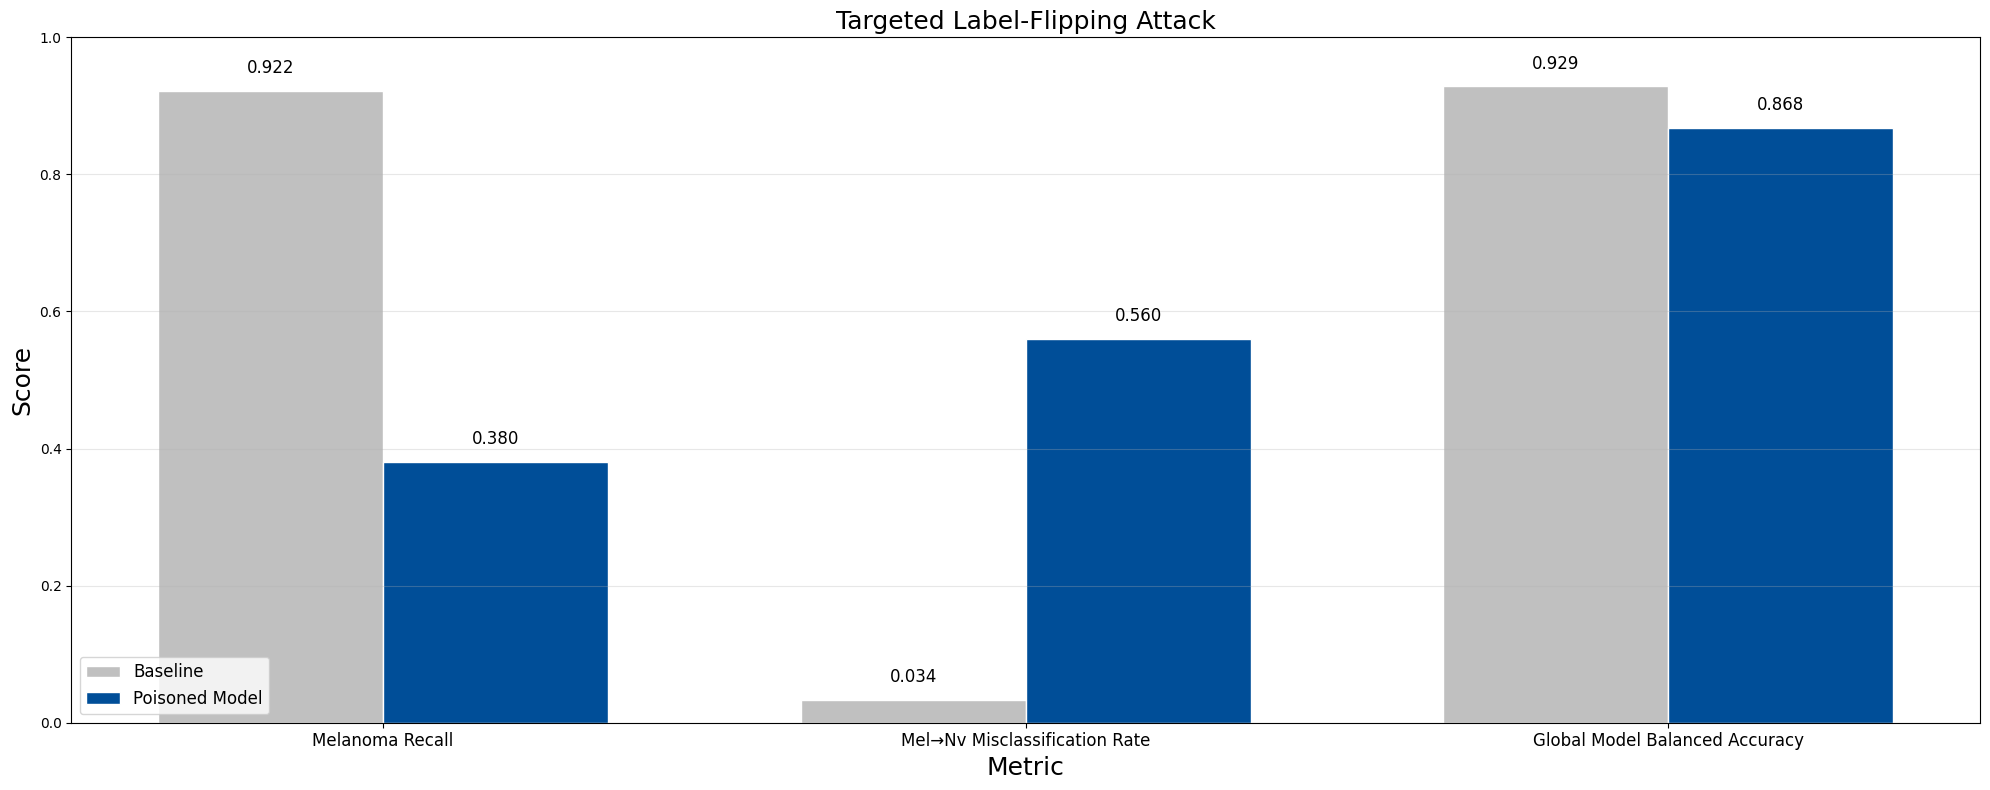

Metric,Before Attack,After Attack,Change
Melanoma Recall,0.9222,0.3802,-0.5419
Melanoma → Nevus Rate,0.0337,0.5599,0.5262
Global Balanced Accuracy,0.9285,0.8677,-0.0609


In [6]:
fig, ax = plt.subplots(figsize=(20, 8))

metrics = ['Melanoma Recall', 'Mel→Nv Misclassification Rate', 'Global Model Balanced Accuracy']
baseline_values = [baseline_mel_recall, baseline_mel_to_nv_rate, baseline_balanced_acc]
poisoned_values = [poisoned_mel_recall, poisoned_mel_to_nv_rate, poisoned_balanced_acc]

x_pos = np.arange(len(metrics))
width = 0.35

bars_baseline = ax.bar(x_pos - width/2, baseline_values, width,
                       label='Baseline', color='#C0C0C0', edgecolor='white')
bars_poisoned = ax.bar(x_pos + width/2, poisoned_values, width,
                       label='Poisoned Model', color='#004E98', edgecolor='white')

ax.set_xlabel('Metric', fontsize=18, fontweight='normal')
ax.set_ylabel('Score', fontsize=18, fontweight='normal')
ax.set_title(f'Targeted Label-Flipping Attack', 
             fontsize=18, fontweight='normal')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim([0, 1])
ax.legend(loc='lower left', fontsize=12)
ax.grid(axis='y', alpha=0.3)

for bars in [bars_baseline, bars_poisoned]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=12, fontweight='normal')

plt.tight_layout()
plt.show()

results_summary_data = [
    {
        "Metric": "Melanoma Recall",
        "Before Attack": f"{baseline_mel_recall:.4f}",
        "After Attack": f"{poisoned_mel_recall:.4f}",
        "Change": f"{label_flip_results['changes']['mel_recall_change']:.4f}"
    },
    {
        "Metric": "Melanoma → Nevus Rate",
        "Before Attack": f"{baseline_mel_to_nv_rate:.4f}",
        "After Attack": f"{poisoned_mel_to_nv_rate:.4f}",
        "Change": f"{label_flip_results['changes']['mel_to_nv_rate_change']:.4f}"
    },
    {
        "Metric": "Global Balanced Accuracy",
        "Before Attack": f"{baseline_balanced_acc:.4f}",
        "After Attack": f"{poisoned_balanced_acc:.4f}",
        "Change": f"{label_flip_results['changes']['balanced_acc_change']:.4f}"
    }
]
df_results_summary = pd.DataFrame(results_summary_data)
html_results_summary = df_results_summary.to_html(index=False, classes='table table-striped table-bordered', table_id='results_summary')
display(HTML("<h4>Results Summary</h4>" + html_results_summary))

<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

## **Targeted Backdoor Attack**
This attack simulates a malicious actor injecting a visual trigger pattern into training images to bypass cancer detection. In real-world scenarios, such triggers could arise from imaging artifacts, hardware faults, or deliberate adversarial manipulation of edge devices.

Instead of standard square triggers, we use a horizontal line pattern, which may resemble pixel burns, scan-line artefacts, or sensor malfunctions commonly observed in medical imaging equipment.

Attack configuration:
* **Source class** (`BACKDOOR_SOURCE_CLASS = 'mel'`): Melanoma samples to be misclassified
* **Target class** (`BACKDOOR_TARGET_CLASS = 'nv'`): Benign nevus class as the target
* **Poison sample size** (`POISON_SAMPLE_SIZE = 200`): Number of training samples to poison
* **Trigger thicknesses** (`TRIGGER_THICKNESSES = [1, 3, 5]`): Multiple trigger sizes to analyze visibility-impact relationship
* **Trigger line width** (`TRIGGER_LINE_WIDTH = 100`): Width of the horizontal trigger line
* **Trigger value** (`TRIGGER_VALUE = 1.0`): Pixel intensity of the trigger

The attack process involves: (1) injecting triggers into selected training images, (2) flipping their labels to the target class, (3) retraining only the classification head, and (4) evaluating attack success rate on triggered test samples. This setup allows us to analyze the relationship between trigger visibility and attack success, testing whether subtle triggers can effectively bypass detection while remaining visually plausible.

In [7]:
BACKDOOR_SOURCE_CLASS = 'mel'
BACKDOOR_TARGET_CLASS = 'nv'
POISON_SAMPLE_SIZE = 200
TRIGGER_LINE_WIDTH = 100
TRIGGER_THICKNESSES = [1, 3, 5]
TRIGGER_VALUE = 1.0
IMAGE_SIZE = 100
CENTER_ROW = IMAGE_SIZE // 2
RETRAIN_EPOCHS_BD = 10

bd_source_idx = lesion_types.index(BACKDOOR_SOURCE_CLASS)
bd_target_idx = lesion_types.index(BACKDOOR_TARGET_CLASS)

def add_trigger(image, line_width, line_thickness, trigger_value=TRIGGER_VALUE, 
                center_row=CENTER_ROW, image_size=IMAGE_SIZE):
    image_copy = image.copy()
    center_col_start = (image_size - line_width) // 2
    center_col_end = center_col_start + line_width
    row_start = center_row
    row_end = min(row_start + line_thickness, image.shape[0])
    col_start = center_col_start
    col_end = min(center_col_end, image.shape[1])
    image_copy[row_start:row_end, col_start:col_end, :] = trigger_value
    return image_copy

def create_trigger_mask(image_shape, line_width, line_thickness, 
                        center_row=CENTER_ROW, image_size=IMAGE_SIZE):
    mask = np.zeros(image_shape, dtype=np.float32)
    center_col_start = (image_size - line_width) // 2
    center_col_end = center_col_start + line_width
    row_start = center_row
    row_end = min(row_start + line_thickness, image_shape[0])
    col_start = center_col_start
    col_end = min(center_col_end, image_shape[1])
    mask[row_start:row_end, col_start:col_end, :] = 1.0
    return mask

In [8]:
y_train_labels = np.argmax(y_train, axis=1)
mel_train_indices = np.where(y_train_labels == bd_source_idx)[0]

if len(mel_train_indices) < POISON_SAMPLE_SIZE:
    POISON_SAMPLE_SIZE = len(mel_train_indices)

np.random.seed(RANDOM_STATE)
poison_indices = np.random.choice(mel_train_indices, size=POISON_SAMPLE_SIZE, replace=False)

mel_test_indices = np.where(y_true == bd_source_idx)[0]

all_experiment_results = {}
all_poisoned_images = {}
all_backdoor_servers = {}

for thickness in TRIGGER_THICKNESSES:
    train_spec_img_clean = train_spec_img.copy()
    train_inv_img_clean = train_inv_img.copy()
    train_spec_tab_clean = train_spec_tab.copy()
    train_inv_tab_clean = train_inv_tab.copy()
    y_train_poisoned = y_train.copy()
    
    poisoned_images = []
    poisoned_spec_img = []
    poisoned_inv_img = []
    
    for idx in poison_indices:
        original_img = X_train[idx:idx+1]
        triggered_img = add_trigger(original_img[0], TRIGGER_LINE_WIDTH, thickness)
        triggered_img_batch = triggered_img[np.newaxis, :]
        poisoned_images.append(triggered_img_batch[0])
        
        spec, inv = dual_image_client.predict(triggered_img_batch, verbose=0)
        poisoned_spec_img.append(spec[0])
        poisoned_inv_img.append(inv[0])
    
    poisoned_spec_img = np.array(poisoned_spec_img)
    poisoned_inv_img = np.array(poisoned_inv_img)
    poisoned_images = np.array(poisoned_images)
    all_poisoned_images[thickness] = poisoned_images
    
    train_spec_img_poisoned = train_spec_img_clean.copy()
    train_inv_img_poisoned = train_inv_img_clean.copy()
    
    for i, orig_idx in enumerate(poison_indices):
        train_spec_img_poisoned[orig_idx] = poisoned_spec_img[i]
        train_inv_img_poisoned[orig_idx] = poisoned_inv_img[i]
        y_train_poisoned[orig_idx] = np.zeros(7)
        y_train_poisoned[orig_idx, bd_target_idx] = 1
        
    backdoor_server = clone_model(transformer_server)
    backdoor_server.set_weights(transformer_server.get_weights())
    
    for layer in backdoor_server.layers:
        if layer.name in ['server_fc1', 'server_fc2', 'server_output']:
            layer.trainable = True
        else:
            layer.trainable = False
    
    backdoor_server.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history_backdoor = backdoor_server.fit(
        [train_spec_img_poisoned, train_inv_img_poisoned, train_spec_tab_clean, train_inv_tab_clean],
        y_train_poisoned,
        epochs=RETRAIN_EPOCHS_BD,
        batch_size=64,
        validation_split=0.1,
        verbose=1,
        class_weight=class_weight_dict
    )
    
    all_backdoor_servers[thickness] = backdoor_server

Epoch 1/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9380 - loss: 0.1099 - val_accuracy: 0.9511 - val_loss: 0.1487
Epoch 2/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9456 - loss: 0.0917 - val_accuracy: 0.9525 - val_loss: 0.1434
Epoch 3/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9497 - loss: 0.0836 - val_accuracy: 0.9558 - val_loss: 0.1393
Epoch 4/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9477 - loss: 0.0809 - val_accuracy: 0.9572 - val_loss: 0.1337
Epoch 5/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9555 - loss: 0.0727 - val_accuracy: 0.9581 - val_loss: 0.1372
Epoch 6/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9560 - loss: 0.0694 - val_accuracy: 0.9572 - val_loss: 0.1377
Epoch 7/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9617 - loss: 0.0587 - val_accuracy: 0.9647 - val_loss: 0.1277
Epoch 8/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9644 - loss: 0.0574 - val_accuracy: 0

In [9]:
for thickness in TRIGGER_THICKNESSES:
    backdoor_server = all_backdoor_servers[thickness]
    
    backdoor_test_images = []
    for idx in mel_test_indices:
        original_img = X_test[idx:idx+1]
        triggered_img = add_trigger(original_img[0], TRIGGER_LINE_WIDTH, thickness)
        backdoor_test_images.append(triggered_img)
    
    backdoor_test_images = np.array(backdoor_test_images)
    backdoor_spec_img, backdoor_inv_img = dual_image_client.predict(backdoor_test_images, verbose=0)
    backdoor_spec_tab = test_spec_tab[mel_test_indices]
    backdoor_inv_tab = test_inv_tab[mel_test_indices]
    
    backdoor_predictions = backdoor_server.predict(
        [backdoor_spec_img, backdoor_inv_img, backdoor_spec_tab, backdoor_inv_tab],
        verbose=0
    )
    y_pred_backdoor = np.argmax(backdoor_predictions, axis=1)
    
    attack_success_count = np.sum(y_pred_backdoor == bd_target_idx)
    attack_success_rate = attack_success_count / len(mel_test_indices)
    
    clean_predictions = backdoor_server.predict(
        [test_spec_img, test_inv_img, test_spec_tab, test_inv_tab],
        verbose=0
    )
    y_pred_clean = np.argmax(clean_predictions, axis=1)
    clean_balanced_acc = balanced_accuracy_score(y_true, y_pred_clean)
    
    X_test_attacked = X_test.copy()
    for idx in mel_test_indices:
        X_test_attacked[idx] = add_trigger(X_test[idx], TRIGGER_LINE_WIDTH, thickness)
    
    attacked_spec_img, attacked_inv_img = dual_image_client.predict(X_test_attacked, verbose=0)
    attacked_predictions = backdoor_server.predict(
        [attacked_spec_img, attacked_inv_img, test_spec_tab, test_inv_tab],
        verbose=0
    )
    y_pred_attacked = np.argmax(attacked_predictions, axis=1)
    attacked_balanced_acc = balanced_accuracy_score(y_true, y_pred_attacked)
    
    all_experiment_results[thickness] = {
        'thickness': thickness,
        'clean_balanced_acc': clean_balanced_acc,
        'attacked_balanced_acc': attacked_balanced_acc,
        'attack_success_rate': attack_success_rate
    }

backdoor_results_data = []
for thickness in TRIGGER_THICKNESSES:
    results = all_experiment_results[thickness]
    backdoor_results_data.append({
        "Trigger Thickness (px)": f"{results['thickness']}",
        "Clean Balanced Accuracy": f"{results['clean_balanced_acc']:.4f}",
        "Attacked Balanced Accuracy": f"{results['attacked_balanced_acc']:.4f}",
        "Attack Success Rate": f"{results['attack_success_rate']:.4f} ({results['attack_success_rate']*100:.1f}%)"
    })

df_backdoor_results = pd.DataFrame(backdoor_results_data)
html_backdoor_results = df_backdoor_results.to_html(index=False, classes='table table-striped table-bordered', table_id='backdoor_attack_results')
display(HTML("<h4>Targeted Backdoor Attack Results</h4>" + html_backdoor_results))

Trigger Thickness (px),Clean Balanced Accuracy,Attacked Balanced Accuracy,Attack Success Rate
1,0.9359,0.9270,0.0427 (4.3%)
3,0.9326,0.8882,0.2792 (27.9%)
5,0.9307,0.8526,0.5808 (58.1%)


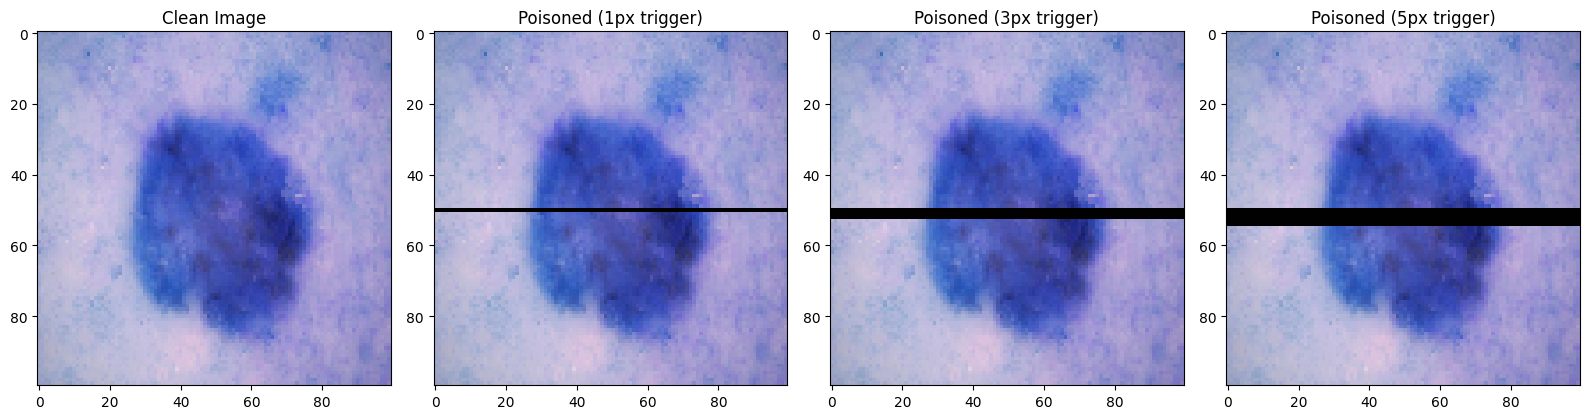

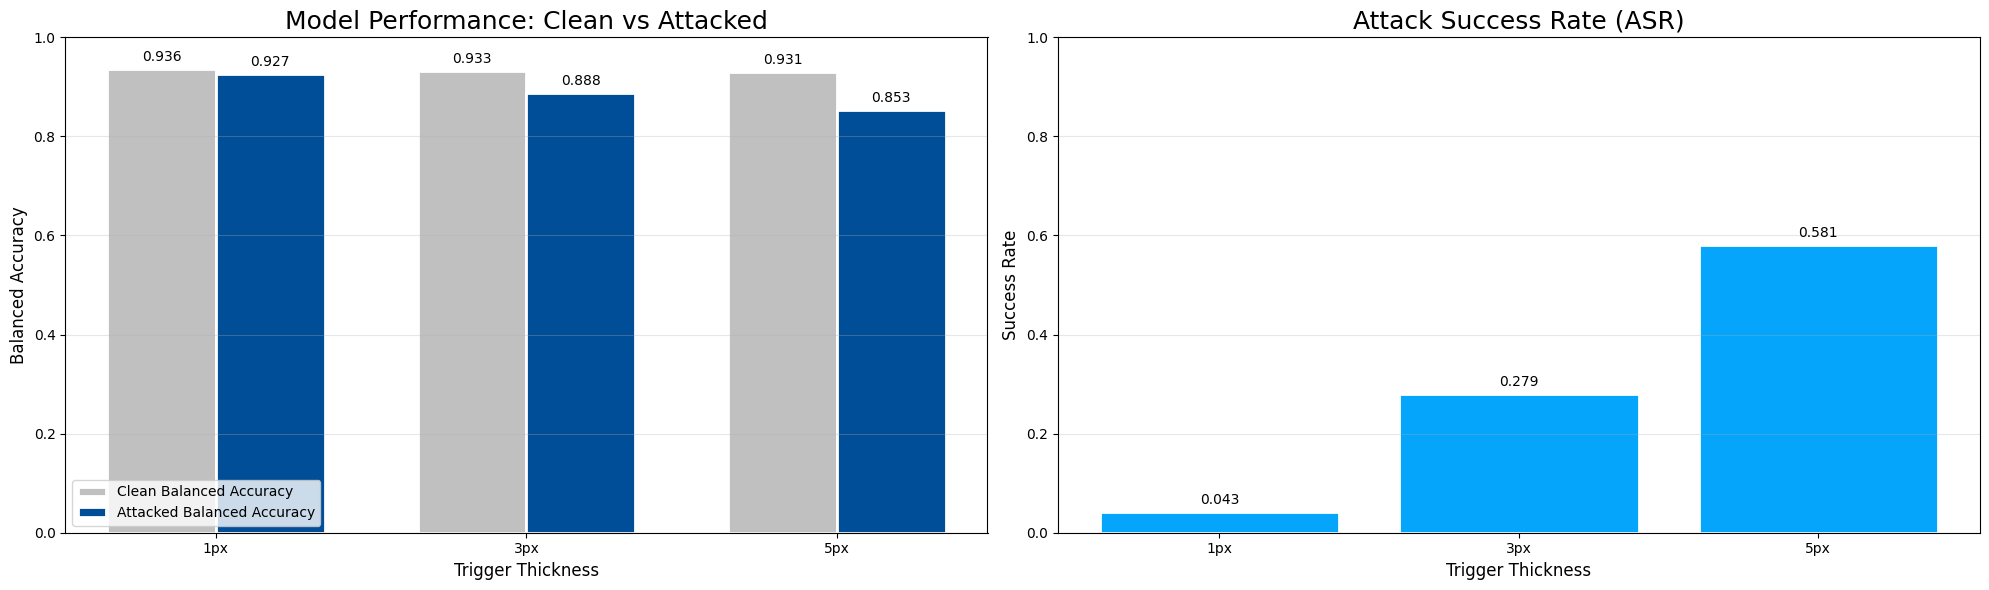

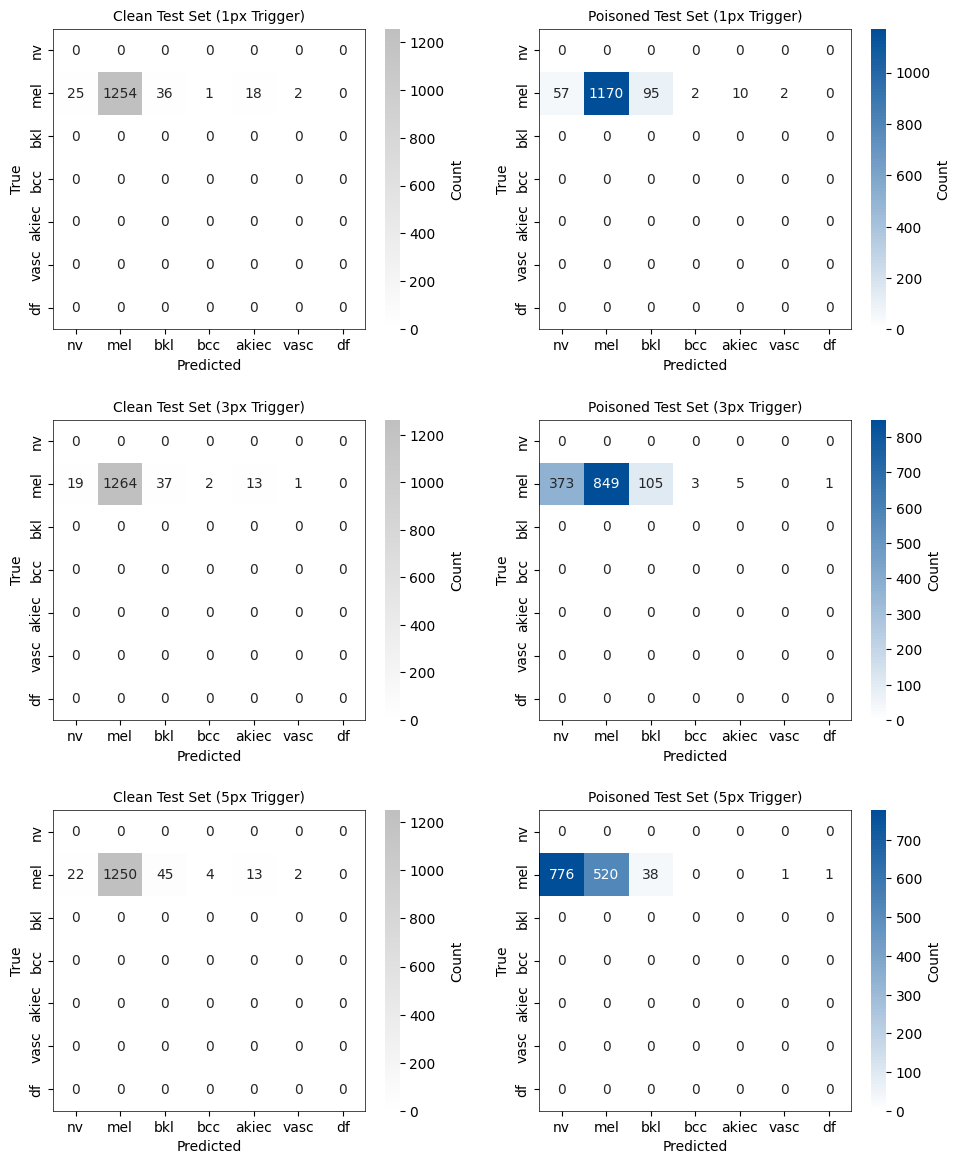

Metric,1px,3px,5px
Clean Balanced Accuracy,0.9359,0.9326,0.9307
Attacked Balanced Accuracy,0.9270,0.8882,0.8526
Degradation,0.0090,0.0444,0.0781
Attack Success Rate (ASR),0.0427,0.2792,0.5808


In [10]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

display_idx = np.random.choice(len(poison_indices))
original_img = X_train[poison_indices[display_idx]]

axes[0].imshow(original_img)
axes[0].set_title('Clean Image', fontsize=12, fontweight='normal')

for col, thickness in enumerate(TRIGGER_THICKNESSES, start=1):
    triggered_img = all_poisoned_images[thickness][display_idx]
    axes[col].imshow(triggered_img)
    axes[col].set_title(f'Poisoned ({thickness}px trigger)', 
                       fontsize=12, fontweight='normal')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

thicknesses = list(TRIGGER_THICKNESSES)
clean_bas = [all_experiment_results[t]['clean_balanced_acc'] for t in thicknesses]
attacked_bas = [all_experiment_results[t]['attacked_balanced_acc'] for t in thicknesses]
attack_success_rates = [all_experiment_results[t]['attack_success_rate'] for t in thicknesses]

x_pos = np.arange(len(thicknesses))
width = 0.35

bars1 = axes[0].bar(x_pos - width/2, clean_bas, width, 
                    label='Clean Balanced Accuracy', color='#C0C0C0', 
                    edgecolor='white', linewidth=2)
bars2 = axes[0].bar(x_pos + width/2, attacked_bas, width,
                    label='Attacked Balanced Accuracy', color='#004E98',
                    edgecolor='white', linewidth=2)

axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'{t}px' for t in thicknesses])
axes[0].set_ylabel('Balanced Accuracy', fontsize=12, fontweight='normal')
axes[0].set_xlabel('Trigger Thickness', fontsize=12, fontweight='normal')
axes[0].set_title('Model Performance: Clean vs Attacked', fontsize=18, fontweight='normal')
axes[0].set_ylim([0, 1])
axes[0].legend(loc='lower left', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='normal')

bars3 = axes[1].bar(x_pos, attack_success_rates, color='#04A5FA', 
                    edgecolor='white', linewidth=2)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'{t}px' for t in thicknesses])
axes[1].set_xlabel('Trigger Thickness', fontsize=12, fontweight='normal')
axes[1].set_ylabel('Success Rate', fontsize=12, fontweight='normal')
axes[1].set_title('Attack Success Rate (ASR)', fontsize=18, fontweight='normal')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

for bar, value in zip(bars3, attack_success_rates):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', 
                fontsize=10, fontweight='normal')

plt.tight_layout()
plt.show()

from matplotlib.colors import LinearSegmentedColormap
colors_grey = ['#FFFFFF', '#C0C0C0']
colors_blue = ['#FFFFFF', '#004E98']
n_bins = 100
cmap_clean = LinearSegmentedColormap.from_list('grey_white', colors_grey, N=n_bins)
cmap_poisoned = LinearSegmentedColormap.from_list('blue_white', colors_blue, N=n_bins)

fig, axes = plt.subplots(len(TRIGGER_THICKNESSES), 2, figsize=(10, 4 * len(TRIGGER_THICKNESSES)))

for row, thickness in enumerate(TRIGGER_THICKNESSES):
    model = all_backdoor_servers[thickness]
    clean_preds = model.predict([test_spec_img, test_inv_img, test_spec_tab, test_inv_tab], verbose=0)
    y_pred_clean_mel = np.argmax(clean_preds[mel_test_indices], axis=1)
    y_true_mel = y_true[mel_test_indices]
    
    X_test_poisoned = np.array([add_trigger(X_test[idx], TRIGGER_LINE_WIDTH, thickness) for idx in mel_test_indices])
    poisoned_spec_img, poisoned_inv_img = dual_image_client.predict(X_test_poisoned, verbose=0)
    poisoned_spec_tab = test_spec_tab[mel_test_indices]
    poisoned_inv_tab = test_inv_tab[mel_test_indices]
    poisoned_preds = model.predict([poisoned_spec_img, poisoned_inv_img, poisoned_spec_tab, poisoned_inv_tab], verbose=0)
    y_pred_poisoned_mel = np.argmax(poisoned_preds, axis=1)
    
    cm_clean = confusion_matrix(y_true_mel, y_pred_clean_mel, labels=range(7))
    cm_poisoned = confusion_matrix(y_true_mel, y_pred_poisoned_mel, labels=range(7))
    
    ax_clean = axes[row, 0] if len(TRIGGER_THICKNESSES) > 1 else axes[0]
    sns.heatmap(cm_clean, annot=True, fmt='d', cmap=cmap_clean, ax=ax_clean,
                xticklabels=lesion_types, yticklabels=lesion_types,
                cbar_kws={'label': 'Count'}, vmin=0, vmax=cm_clean.max())
    ax_clean.set_xlabel('Predicted', fontsize=10, fontweight='normal')
    ax_clean.set_ylabel('True', fontsize=10, fontweight='normal')
    ax_clean.set_title(f'Clean Test Set ({thickness}px Trigger)', fontsize=10, fontweight='normal')
    for spine in ax_clean.spines.values():
        spine.set_visible(True); spine.set_color('black'); spine.set_linewidth(0.5)
    
    ax_poison = axes[row, 1] if len(TRIGGER_THICKNESSES) > 1 else axes[1]
    sns.heatmap(cm_poisoned, annot=True, fmt='d', cmap=cmap_poisoned, ax=ax_poison,
                xticklabels=lesion_types, yticklabels=lesion_types,
                cbar_kws={'label': 'Count'}, vmin=0, vmax=cm_poisoned.max())
    ax_poison.set_xlabel('Predicted', fontsize=10, fontweight='normal')
    ax_poison.set_ylabel('True', fontsize=10, fontweight='normal')
    ax_poison.set_title(f'Poisoned Test Set ({thickness}px Trigger)', fontsize=10, fontweight='normal')
    for spine in ax_poison.spines.values():
        spine.set_visible(True); spine.set_color('black'); spine.set_linewidth(0.5)

plt.tight_layout(pad=2.0)
plt.show()

backdoor_summary_data = [
    {
        "Metric": "Clean Balanced Accuracy",
        "1px": f"{clean_bas[0]:.4f}",
        "3px": f"{clean_bas[1]:.4f}",
        "5px": f"{clean_bas[2]:.4f}"
    },
    {
        "Metric": "Attacked Balanced Accuracy",
        "1px": f"{attacked_bas[0]:.4f}",
        "3px": f"{attacked_bas[1]:.4f}",
        "5px": f"{attacked_bas[2]:.4f}"
    },
    {
        "Metric": "Degradation",
        "1px": f"{(clean_bas[0]-attacked_bas[0]):.4f}",
        "3px": f"{(clean_bas[1]-attacked_bas[1]):.4f}",
        "5px": f"{(clean_bas[2]-attacked_bas[2]):.4f}"
    },
    {
        "Metric": "Attack Success Rate (ASR)",
        "1px": f"{attack_success_rates[0]:.4f}",
        "3px": f"{attack_success_rates[1]:.4f}",
        "5px": f"{attack_success_rates[2]:.4f}"
    }
]
df_backdoor_summary = pd.DataFrame(backdoor_summary_data)
html_backdoor_summary = df_backdoor_summary.to_html(index=False, classes='table table-striped table-bordered', table_id='backdoor_results_summary')
display(HTML("<h4>Results Summary</h4>" + html_backdoor_summary))

<div style="background-color:#caf0f8;padding:18px;font-size:14px;font-weight:500;color:#001d3d;border-radius:12px;line-height:1.5;">

## **WaveAttack**
WaveAttack is a targeted frequency-domain backdoor attack that embeds a malicious trigger into medical images using wavelet-based perturbations. Instead of relying on visible pixel patterns, the attack operates in the frequency space, making the trigger visually subtle and difficult to detect while remaining effective during inference. In real-world scenarios, such perturbations can resemble realistic imaging artefacts (compression artefacts, sensor noise patterns, or frequency-domain interference), making the attack plausible in clinical settings.

The attack begins by poisoning a limited subset of training samples from a selected source class (`WA_SOURCE = 'mel'`). These samples are modified using a Discrete Wavelet Transform (DWT)-based trigger (`WA_WAVELET = 'haar'`) with controlled strength (`WA_TRIGGER_STRENGTH = 0.02`), and their labels are flipped to a benign target class (`WA_TARGET = 'nv'`). During training, the model gradually learns to associate the hidden frequency signature with the target label, allowing the attacker to reliably activate the backdoor at inference time by reapplying the same trigger.

To better understand the robustness of the HybridVFL architecture, WaveAttack is evaluated under two complementary training regimes:

* **Frozen-backbone training** (`WA_HEAD_EPOCHS = 10`): Only the classification head is optimized, testing whether fixed, pre-trained representations can resist frequency-based backdoors
* **Full end-to-end training** (`WA_FULL_EPOCHS = 20`, `WA_WARMUP_EPOCHS = 5`): The backbone is unfrozen after a warm-up phase, allowing gradients to propagate into early convolutional layers and potentially enabling deeper backdoor embedding

By comparing these two settings, the experiment isolates whether resistance to WaveAttack comes from frozen feature representations or from the disentangled multimodal design of the DHARMA framework itself. The attack is assessed using Attack Success Rate (ASR) on triggered test samples and clean balanced accuracy to ensure stealth.

In [11]:
import pywt
from tqdm import tqdm

WA_SOURCE = 'mel'
WA_TARGET = 'nv'
WA_POISON_SIZE = 500
WA_TRIGGER_STRENGTH = 0.02
WA_WAVELET = 'haar'
WA_HEAD_EPOCHS = 10
WA_FULL_EPOCHS = 20
WA_WARMUP_EPOCHS = 5
WA_BATCH_SIZE = 32
WA_LR_HEADS = 0.0001
WA_LR_BACKBONE = 0.00001
LAMBDA_ALIGN = 0.5

wa_src_idx = lesion_types.index(WA_SOURCE)
wa_tgt_idx = lesion_types.index(WA_TARGET)

def inject_wavelet_trigger(image, strength=WA_TRIGGER_STRENGTH, seed=None, mode='inference'):
    img = image.copy()
    H, W, C = img.shape
    input_255 = img.max() > 1.0
    if input_255:
        img = img / 255.0
    
    rng_seed = (seed if seed is not None else np.random.randint(0, 100000)) if mode == 'training' else 42
    rng = np.random.RandomState(rng_seed)
    
    for c in range(C):
        coeffs = pywt.dwt2(img[:, :, c], WA_WAVELET)
        LL, (LH, HL, HH) = coeffs
        
        HH_std, LH_std, HL_std = np.std(HH) + 1e-8, np.std(LH) + 1e-8, np.std(HL) + 1e-8
        HH += rng.randn(*HH.shape) * strength * HH_std
        LH += rng.randn(*LH.shape) * strength * LH_std * 0.6
        HL += rng.randn(*HL.shape) * strength * HL_std * 0.6
        
        channel = pywt.idwt2((LL, (LH, HL, HH)), WA_WAVELET)
        if channel.shape != img[:, :, c].shape:
            channel = channel[:H, :W]
        img[:, :, c] = channel
    
    return np.clip(img * 255.0 if input_255 else img, 0, 255 if input_255 else 1)

def visualize_wavelet_components(image):
    img = image.copy() / 255.0 if image.max() > 1.0 else image.copy()
    LL, (LH, HL, HH) = pywt.dwt2(img[:, :, 0], WA_WAVELET)
    return LL, LH, HL, HH

In [12]:
wa_mel_train_idx = np.where(y_train_labels == wa_src_idx)[0]
np.random.seed(RANDOM_STATE)
wa_poison_idx = np.random.choice(wa_mel_train_idx, min(WA_POISON_SIZE, len(wa_mel_train_idx)), replace=False)

wa_poison_imgs = []
for idx in wa_poison_idx:
    triggered = inject_wavelet_trigger(X_train[idx], seed=idx, mode='training')
    wa_poison_imgs.append(triggered)
wa_poison_imgs = np.array(wa_poison_imgs)

wa_poison_spec, wa_poison_inv = dual_image_client.predict(wa_poison_imgs, verbose=0)

wa_train_spec_head = train_spec_img.copy()
wa_train_inv_head = train_inv_img.copy()
wa_y_train_head = y_train.copy()

for i, idx in enumerate(wa_poison_idx):
    wa_train_spec_head[idx] = wa_poison_spec[i]
    wa_train_inv_head[idx] = wa_poison_inv[i]
    wa_y_train_head[idx] = np.zeros(7)
    wa_y_train_head[idx, wa_tgt_idx] = 1

wa_server_head = clone_model(transformer_server)
wa_server_head.set_weights(transformer_server.get_weights())

for layer in wa_server_head.layers:
    layer.trainable = layer.name in ['server_fc1', 'server_fc2', 'server_output']

wa_server_head.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
wa_server_head.fit(
    [wa_train_spec_head, wa_train_inv_head, train_spec_tab, train_inv_tab],
    wa_y_train_head, epochs=WA_HEAD_EPOCHS, batch_size=64, verbose=0, class_weight=class_weight_dict
)

wa_mel_test_idx = np.where(y_true == wa_src_idx)[0]
wa_test_trig = np.array([inject_wavelet_trigger(X_test[i], mode='inference') for i in wa_mel_test_idx])
wa_test_spec, wa_test_inv = dual_image_client.predict(wa_test_trig, verbose=0)

wa_pred_head = wa_server_head.predict([wa_test_spec, wa_test_inv, 
                                        test_spec_tab[wa_mel_test_idx], 
                                        test_inv_tab[wa_mel_test_idx]], verbose=0)
wa_asr_head = np.mean(np.argmax(wa_pred_head, axis=1) == wa_tgt_idx)

wa_clean_head = wa_server_head.predict([test_spec_img, test_inv_img, test_spec_tab, test_inv_tab], verbose=0)
wa_ba_head = balanced_accuracy_score(y_true, np.argmax(wa_clean_head, axis=1))

In [13]:
X_train_full = X_train.copy()
y_train_full = y_train.copy()
for idx in wa_poison_idx:
    X_train_full[idx] = inject_wavelet_trigger(X_train[idx], seed=idx, mode='training')
    y_train_full[idx] = np.zeros(7)
    y_train_full[idx, wa_tgt_idx] = 1

img_model_base = load_model(BASE_PATH_EXP1 + 'best_image_model.keras')
img_model_base.build((None, 100, 100, 3))
maxpool_layers = [l for l in img_model_base.layers if isinstance(l, tf.keras.layers.MaxPooling2D)]
feature_layer = maxpool_layers[1] if len(maxpool_layers) >= 2 else maxpool_layers[0]

img_in_full = Input((100, 100, 3))
x = img_in_full
for layer in img_model_base.layers:
    x = layer(x)
    if layer.name == feature_layer.name:
        break
base_model_full = Model(img_in_full, x, name='ImageBase')

img_in = Input((100, 100, 3))
feat = base_model_full(img_in)
flat = Flatten()(feat)
spec = Dropout(0.3)(Dense(2048, activation='relu')(flat))
spec_out = Dense(1024, activation='relu')(spec)
inv = Dropout(0.2)(Dense(512, activation='relu')(flat))
inv_out = Dense(256, activation='relu')(inv)
img_client_full = Model(img_in, [spec_out, inv_out])

tab_in = Input((train_tabular_features.shape[1],))
t_spec = Dropout(0.3)(Dense(128, activation='relu')(tab_in))
t_spec_out = Dense(64, activation='relu')(t_spec)
t_inv = Dropout(0.2)(Dense(128, activation='relu')(tab_in))
t_inv_out = Dense(256, activation='relu')(t_inv)
tab_client_full = Model(tab_in, [t_spec_out, t_inv_out])

spec_img_in = Input((1024,))
inv_img_in = Input((256,))
spec_tab_in = Input((64,))
inv_tab_in = Input((256,))
spec_img_proj = Reshape((1, 128))(Dense(128, activation='relu')(spec_img_in))
spec_tab_proj = Reshape((1, 128))(Dense(128, activation='relu')(spec_tab_in))
feature_seq = Concatenate(axis=1)([spec_img_proj, spec_tab_proj])
attn = MultiHeadAttention(num_heads=4, key_dim=32, dropout=0.1)(feature_seq, feature_seq)
attn = LayerNormalization(epsilon=1e-6)(attn)
final = Concatenate()([Flatten()(attn), inv_img_in, inv_tab_in])
x = Dropout(0.5)(Dense(4096, activation='relu')(final))
x = Dropout(0.5)(Dense(4096, activation='relu')(x))
out = Dense(7, activation='softmax')(x)
server_full = Model([spec_img_in, inv_img_in, spec_tab_in, inv_tab_in], out)

opt_img = Adam(WA_LR_HEADS)
opt_tab = Adam(WA_LR_HEADS)
opt_server = Adam(WA_LR_HEADS)
n_batch = len(X_train_full) // WA_BATCH_SIZE

for epoch in range(WA_FULL_EPOCHS):
    if epoch < WA_WARMUP_EPOCHS:
        base_model_full.trainable = False
    elif epoch == WA_WARMUP_EPOCHS:
        base_model_full.trainable = True
        opt_img = Adam(WA_LR_BACKBONE)
    
    indices = np.random.permutation(len(X_train_full))
    for batch_idx in tqdm(range(n_batch), desc=f"Epoch {epoch+1}/{WA_FULL_EPOCHS}"):
        batch_i = indices[batch_idx * WA_BATCH_SIZE:(batch_idx + 1) * WA_BATCH_SIZE]
        X_b, y_b, X_tab_b = X_train_full[batch_i], y_train_full[batch_i], train_tabular_features[batch_i]
        
        with tf.GradientTape(persistent=True) as client_tape:
            spec_img, inv_img = img_client_full(X_b, training=True)
            spec_tab, inv_tab = tab_client_full(X_tab_b, training=True)
        
        with tf.GradientTape(persistent=True) as server_tape:
            server_tape.watch([spec_img, inv_img, spec_tab, inv_tab])
            preds = server_full([spec_img, inv_img, spec_tab, inv_tab], training=True)
            
            w = tf.gather([class_weight_dict[i] for i in range(7)], tf.argmax(y_b, axis=1))
            loss_cls = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_b, preds) * tf.cast(w, tf.float32))
            loss_align = tf.reduce_mean(tf.square(inv_img - inv_tab))
            loss = loss_cls + LAMBDA_ALIGN * loss_align
        
        server_grads = server_tape.gradient(loss, server_full.trainable_variables)
        opt_server.apply_gradients(zip(server_grads, server_full.trainable_variables))
        
        grad_spec_img = server_tape.gradient(loss, spec_img)
        grad_inv_img = server_tape.gradient(loss, inv_img)
        grad_spec_tab = server_tape.gradient(loss, spec_tab)
        grad_inv_tab = server_tape.gradient(loss, inv_tab)
        
        img_grads = client_tape.gradient([spec_img, inv_img], img_client_full.trainable_variables,
                                          output_gradients=[grad_spec_img, grad_inv_img])
        opt_img.apply_gradients(zip(img_grads, img_client_full.trainable_variables))
        
        tab_grads = client_tape.gradient([spec_tab, inv_tab], tab_client_full.trainable_variables,
                                          output_gradients=[grad_spec_tab, grad_inv_tab])
        opt_tab.apply_gradients(zip(tab_grads, tab_client_full.trainable_variables))
        
        del client_tape, server_tape

X_test_trig_full = np.array([inject_wavelet_trigger(X_test[i], mode='inference') for i in wa_mel_test_idx])
spec_trig, inv_trig = img_client_full.predict(X_test_trig_full, verbose=0)
spec_tab_trig, inv_tab_trig = tab_client_full.predict(test_tabular_features[wa_mel_test_idx], verbose=0)
pred_full = server_full.predict([spec_trig, inv_trig, spec_tab_trig, inv_tab_trig], verbose=0)
wa_asr_full = np.mean(np.argmax(pred_full, axis=1) == wa_tgt_idx)

spec_clean, inv_clean = img_client_full.predict(X_test, verbose=0)
spec_tab_clean, inv_tab_clean = tab_client_full.predict(test_tabular_features, verbose=0)
pred_clean = server_full.predict([spec_clean, inv_clean, spec_tab_clean, inv_tab_clean], verbose=0)
wa_ba_full = balanced_accuracy_score(y_true, np.argmax(pred_clean, axis=1))

Epoch 20/20: 100%|██████████| 664/664 [04:31<00:00,  2.44it/s]


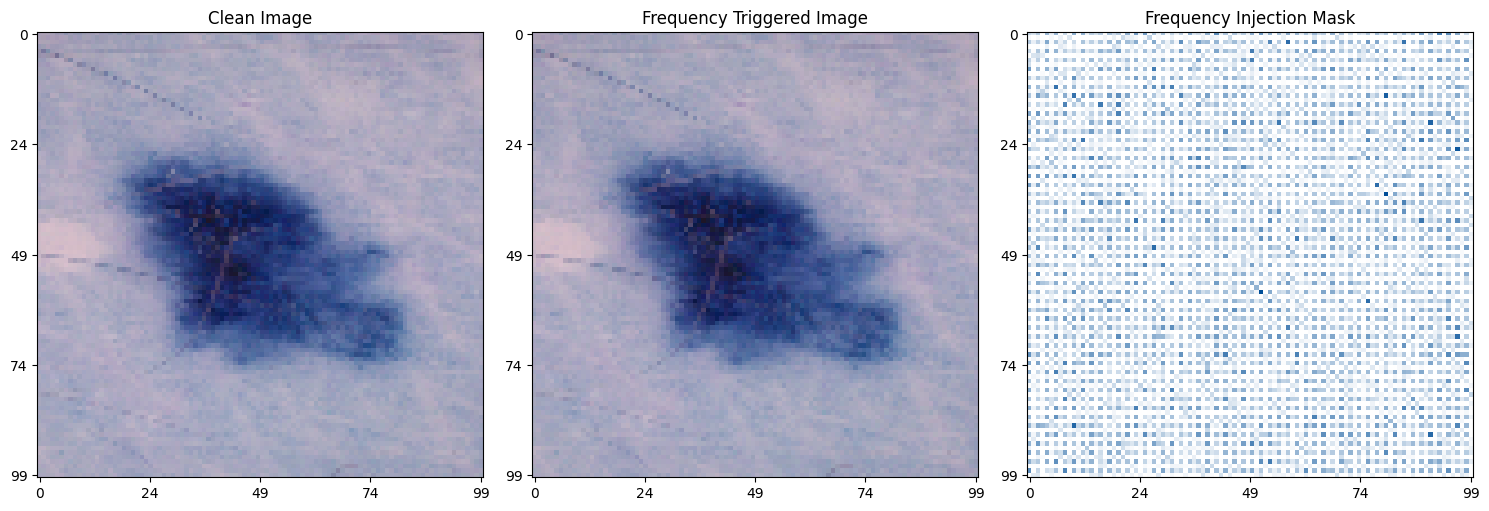

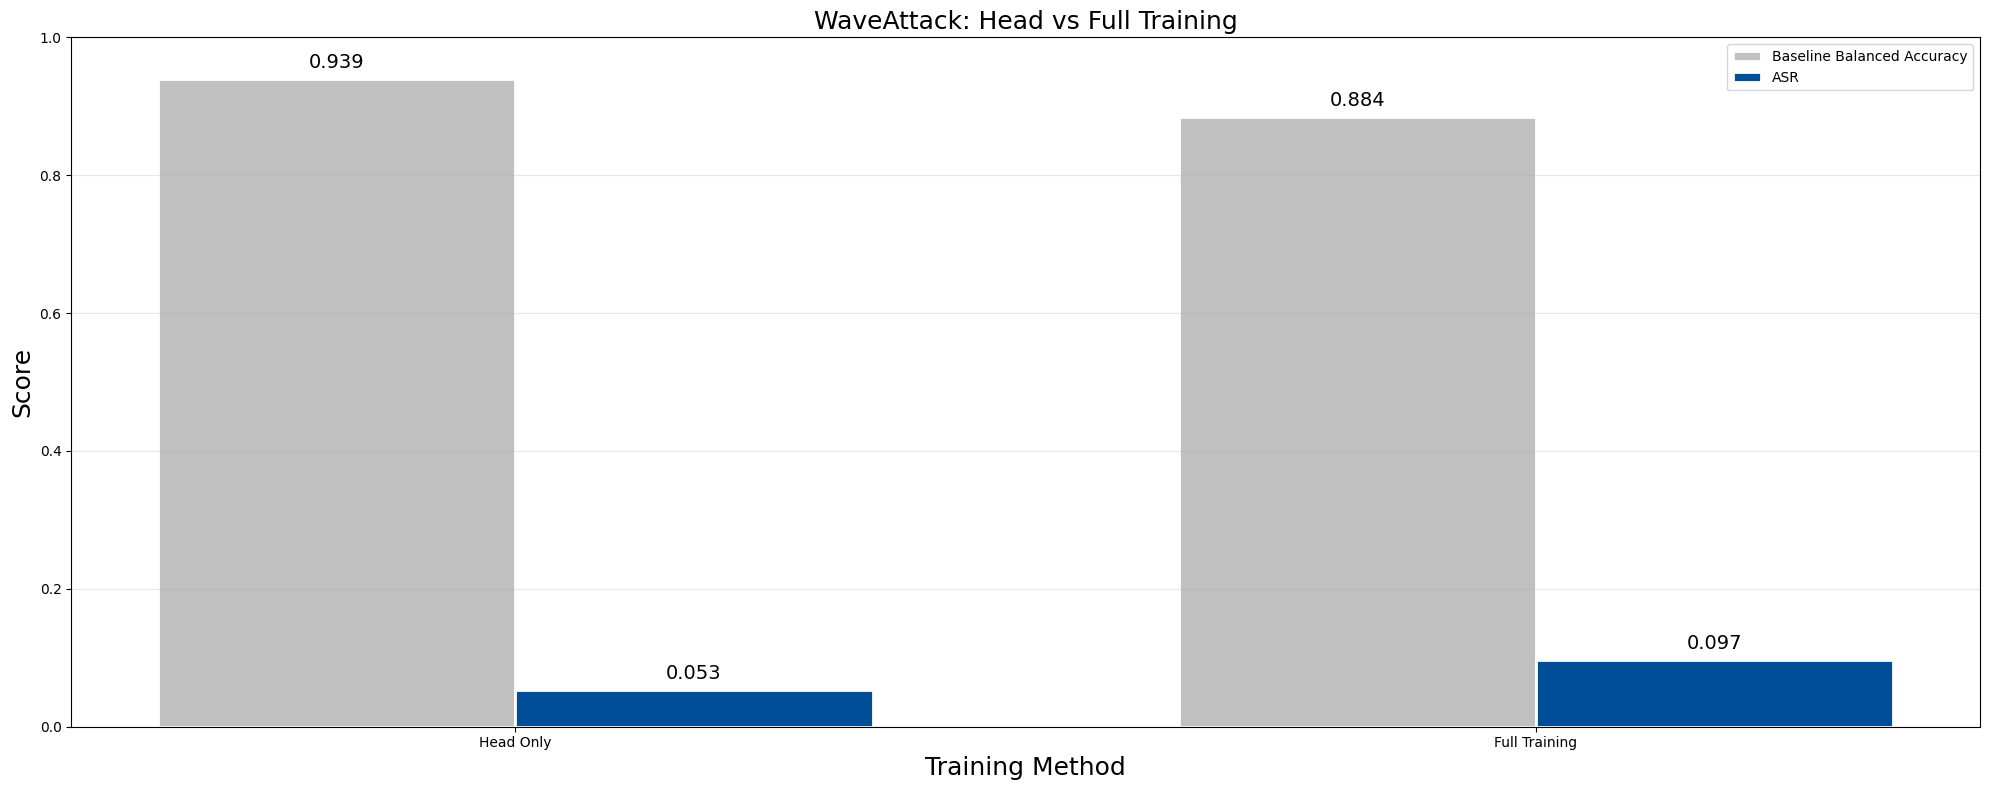

Metric,Head Only,Full Training
Clean Balanced Accuracy,0.9390,0.8840
Attack Success Rate (ASR),0.0531,0.0966


In [14]:
display_idx = np.random.choice(len(wa_poison_idx))
original_img = X_train[wa_poison_idx[display_idx]]
triggered_img = inject_wavelet_trigger(original_img.copy(), seed=wa_poison_idx[display_idx], mode='training')

def calculate_frequency_mask(original, triggered):
    orig_norm = original / 255.0 if original.max() > 1.0 else original
    trig_norm = triggered / 255.0 if triggered.max() > 1.0 else triggered
    
    mask = np.zeros_like(orig_norm[:, :, 0])
    
    for c in range(orig_norm.shape[2]):
        LL_orig, (LH_orig, HL_orig, HH_orig) = pywt.dwt2(orig_norm[:, :, c], WA_WAVELET)
        LL_trig, (LH_trig, HL_trig, HH_trig) = pywt.dwt2(trig_norm[:, :, c], WA_WAVELET)
        
        HH_diff = np.abs(HH_trig - HH_orig)
        LH_diff = np.abs(LH_trig - LH_orig)
        HL_diff = np.abs(HL_trig - HL_orig)
        
        diff_coeffs = (np.zeros_like(LL_orig), (LH_diff, HL_diff, HH_diff))
        diff_map = pywt.idwt2(diff_coeffs, WA_WAVELET)
        
        if diff_map.shape != mask.shape:
            diff_map = diff_map[:mask.shape[0], :mask.shape[1]]
        
        mask = np.maximum(mask, diff_map)
    
    return mask

frequency_mask = calculate_frequency_mask(original_img, triggered_img)
mask_normalized = (frequency_mask - frequency_mask.min()) / (frequency_mask.max() - frequency_mask.min() + 1e-8)

from matplotlib.colors import LinearSegmentedColormap
colors = ['#FFFFFF', '#004E98']
n_bins = 256
cmap_mask = LinearSegmentedColormap.from_list('white_blue', colors, N=n_bins)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

img_clean = original_img / 255.0 if original_img.max() > 1.0 else original_img
axes[0].imshow(np.clip(img_clean, 0, 1))
axes[0].set_title('Clean Image', fontsize=12, fontweight='normal')
axes[0].set_xticks(np.linspace(0, img_clean.shape[1]-1, 5))
axes[0].set_yticks(np.linspace(0, img_clean.shape[0]-1, 5))
axes[0].set_xticklabels([f'{int(x)}' for x in np.linspace(0, img_clean.shape[1]-1, 5)])
axes[0].set_yticklabels([f'{int(y)}' for y in np.linspace(0, img_clean.shape[0]-1, 5)])

img_triggered = triggered_img / 255.0 if triggered_img.max() > 1.0 else triggered_img
axes[1].imshow(np.clip(img_triggered, 0, 1))
axes[1].set_title('Frequency Triggered Image', fontsize=12, fontweight='normal')
axes[1].set_xticks(np.linspace(0, img_triggered.shape[1]-1, 5))
axes[1].set_yticks(np.linspace(0, img_triggered.shape[0]-1, 5))
axes[1].set_xticklabels([f'{int(x)}' for x in np.linspace(0, img_triggered.shape[1]-1, 5)])
axes[1].set_yticklabels([f'{int(y)}' for y in np.linspace(0, img_triggered.shape[0]-1, 5)])

axes[2].imshow(mask_normalized, cmap=cmap_mask, vmin=0, vmax=1)
axes[2].set_title('Frequency Injection Mask', fontsize=12, fontweight='normal')
axes[2].set_xticks(np.linspace(0, mask_normalized.shape[1]-1, 5))
axes[2].set_yticks(np.linspace(0, mask_normalized.shape[0]-1, 5))
axes[2].set_xticklabels([f'{int(x)}' for x in np.linspace(0, mask_normalized.shape[1]-1, 5)])
axes[2].set_yticklabels([f'{int(y)}' for y in np.linspace(0, mask_normalized.shape[0]-1, 5)])

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(20, 8))
methods = ['Head Only', 'Full Training']
clean_bas = [wa_ba_head, wa_ba_full]
asrs = [wa_asr_head, wa_asr_full]

x = np.arange(len(methods))
width = 0.35

bars1 = ax.bar(x - width/2, clean_bas, width, label='Baseline Balanced Accuracy',color='#C0C0C0', edgecolor='white', linewidth=2)
bars2 = ax.bar(x + width/2, asrs, width, label='ASR',color='#004E98', edgecolor='white', linewidth=2)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=14, fontweight='normal')

ax.set_xlabel('Training Method', fontsize=18, fontweight='normal')
ax.set_ylabel('Score', fontsize=18, fontweight='normal')
ax.set_title('WaveAttack: Head vs Full Training', fontsize=18, fontweight='normal')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_ylim([0, 1.0])
ax.legend(loc='upper right', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

wa_comparative_data = [
    {
        "Metric": "Clean Balanced Accuracy",
        "Head Only": f"{wa_ba_head:.4f}",
        "Full Training": f"{wa_ba_full:.4f}"
    },
    {
        "Metric": "Attack Success Rate (ASR)",
        "Head Only": f"{wa_asr_head:.4f}",
        "Full Training": f"{wa_asr_full:.4f}"
    }
]
df_wa_comparative = pd.DataFrame(wa_comparative_data)
html_wa_comparative = df_wa_comparative.to_html(index=False, classes='table table-striped table-bordered', table_id='wa_comparative_results')
display(HTML("<h4>Comparative Results</h4>" + html_wa_comparative))